Neural Network

In [1]:
from keras.src.callbacks import early_stopping
from sklearn.metrics import (matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from joblib import dump
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, regularizers, callbacks
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import keras
import keras_tuner
from keras import layers, regularizers

covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

Clean, Balance, and Split Data

In [2]:
# preprocess data using utils.py
X_clean, y_clean = utils.clean_data(X, y)

X_trainA, X_test, y_trainA, y_test = utils.split_data(X_clean, y_clean)
# todo: use smote to balance set

# X_train, y_train = utils.normalize_data(X_train, y_train)
X_train, y_train = utils.naive_undersample_data(X_trainA, y_trainA)

# create a validation set
validation_ratio = 0.1

X_train, X_val, y_train, y_val = utils.split_data(X_train, y_train, validation_ratio)

Create Model

In [10]:
def build_keras_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(54,1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256, 512]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(
                  hp.Choice('units', [64, 128, 256]),
                  activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.01)
              ))
    model.add(keras.layers.Dense(8, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [11]:
build_keras_model(keras_tuner.HyperParameters())

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


<Sequential name=sequential_1, built=True>

In [17]:
tuner = keras_tuner.GridSearch(
    hypermodel = build_keras_model,
    objective='val_loss',
    max_trials=50,
    overwrite=True,
)

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Summary Statistics

Training of Model

In [18]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Trial 3 Complete [00h 01m 12s]
val_loss: 0.9090740084648132

Best val_loss So Far: 0.9090740084648132
Total elapsed time: 00h 02m 42s


In [19]:
model = tuner.get_best_models(num_models=3)[0]
tuner.search_space_summary()
model.summary()

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Search space summary
Default search space size: 1
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,680 (1.82 MB)

 Trainable params: 476,680 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# retrain on best parameters
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

fitted = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6996 - loss: 0.9302 - val_accuracy: 0.7290 - val_loss: 0.8856
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7195 - loss: 0.8854 - val_accuracy: 0.7122 - val_loss: 0.8847
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7132 - loss: 0.8958 - val_accuracy: 0.7251 - val_loss: 0.8481
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7223 - loss: 0.8730 - val_accuracy: 0.7362 - val_loss: 0.8520
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7269 - loss: 0.8666 - val_accuracy: 0.7368 - val_loss: 0.8705
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7170 - loss: 0.8932 - val_accuracy: 0.7076 - val_loss: 0.9028
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7255 - loss: 0.8668 - val_accuracy: 0.6686 - val_loss: 0.9739
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7231 - loss: 0.8710 - val_accuracy: 0.

 ## Visualizations

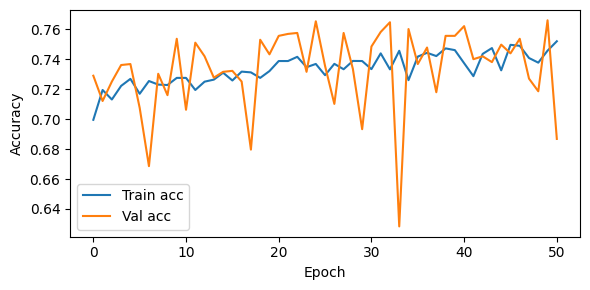

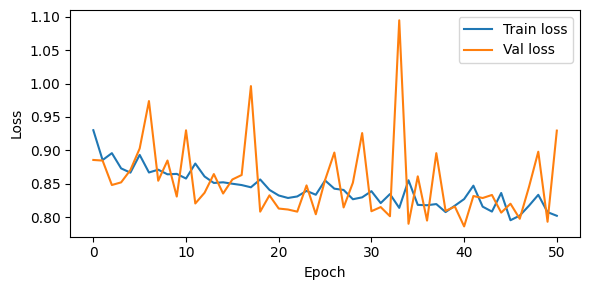

In [21]:
plt.figure(figsize=(6,3))
plt.plot(fitted.history["accuracy"], label="Train acc")
plt.plot(fitted.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fitted.history["loss"], label="Train loss")
plt.plot(fitted.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

## Results

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Test MCC: 0.4288626051514095

Confusion Matrix:
[[27762  7311    15     0  1715   112  5453]
 [13945 27139  1665    25 10998  2363   526]
 [    0    56  4119   468   306  2202     0]
 [    0     0     2   529     0    18     0]
 [    7   108    32     0  1708    44     0]
 [    1    94   458   216   131  2573     0]
 [  388    15     0     0     3     0  3696]]

Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.66      0.66     42368
           2       0.78      0.48      0.59     56661
           3       0.65      0.58      0.61      7151
           4       0.43      0.96      0.59       549
           5       0.11      0.90      0.20      1899
           6       0.35      0.74      0.48      3473
           7       0.38      0.90      0.54      4102

    accuracy                           0.58    116203
   macro avg       0.48      0.75      0.52    116203
weighted avg       0.69    

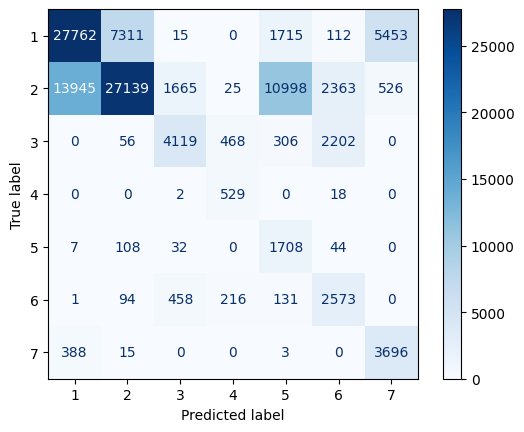

In [22]:
# See how our model does on the test set

# TODO: deal with softmax to a prediction and fix model rigidness.
# todo: categorize using sklearn on the y_true
y_predicted = model.predict(X_test)

# take argmax of y_predicted to find what it predicted
y_pred_idx = [np.argmax(row) for row in y_predicted]

test_mcc = matthews_corrcoef(y_test, y_pred_idx)
print("Test MCC:", test_mcc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_idx))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_idx))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_idx, cmap="Blues")
plt.show()

In [23]:
# dump model
dump(model, "../data/best_neural_network.joblib")

['../data/best_neural_network.joblib']